<a href="https://colab.research.google.com/github/manimoh/bahama_nma_project/blob/master/Working_example_baseline_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [3]:
#@title Data loading
import numpy as np
import copy

alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

# Making a backup so that we don't have to load the data back up again
alldat_backup = copy.copy(alldat)

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [4]:
#@title Import statements (Add more as needed)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss

In [5]:
#@title Helper functions
def rebin_st(st, bin_size):
    '''
    Method to rebin a 2D spike train by summing the spikes from nearby bins

    Inputs:
    st: original spike_train of n neurons * t timebins
    bin_size: Desired bin size (Must be a factor of 't')

    Returns:
    rst: spike_train of n neurons * bin_size timebins
    '''
    rst = np.zeros((st.shape[0], st.shape[1]//bin_size))
    for i in range(rst.shape[1]):
        rst[:,i] = np.sum(st[:,i*bin_size:(i+1)*bin_size], axis=1)
    return rst


def make_features_for_this_region (base_features):
    '''
    Method to make rows of a design_matrix with intra region interaction terms

    Inputs:
    base_features:
    Top n principal components of this region

    Returns:
    A 1D numpy array with all the base features and second order interaction
    terms 
    '''
    features = []
    # First add the base terms
    for f in (base_features):
        features.append(f)
    # Next add the interaction terms
    for i in range(0,len(base_features)):
        features.append(base_features[i]**2)
        for j in range(i+1, len(base_features)):
            features.append(base_features[i]*base_features[j])
    return np.array(features)


def make_features_for_these_regions (base_features_1, base_features_2):
    '''
    Method to create cross-interactions terms from two regions

    Inputs:
    base_features_1 :
    Top n principal components of this region
    base_features_2 :
    Top n principal components of this region

    Returns:
    A 1D numpy array with all the inter-region pairwise interaction terms
    '''
    features = []
    #interactive_terms        
    for i in range(0,len(base_features_1)):
        for j in range(0, len(base_features_2)):
            features.append(base_features_1[i]*base_features_2[j])
    return np.array(features)

def get_primary_features (data, top_n=3):
    '''
    Method to return a dictionary of primary features based on the top_n PCA
    components to be selected from the data

    Inputs:
    data :
    Dictionary with brain region as key and the corresponding data as value
    top_n :
    Top n principal components to be selected
    

    Returns:
    primary_features_dict
    
    Dictionary with brain region as key and the top_n features as value
    '''
    primary_features_dict = {}
    for key in data:
        this_data = data[key]
        pca = PCA(n_components=top_n)
        pca.fit(this_data)
        this_pca = pca.components_
        this_features = (this_pca @ this_data.T).T
        primary_features_dict[key] = this_features
    return primary_features_dict

def normalize_dm (dm_in):
    '''
    Method to return the dm with columns normalized such that each column's standard deviation is 1
    '''
    dm_out = np.array(dm_in)
    for col in range(dm_out.shape[1]):
        norm = dm_out[:,col].std()
        dm_out[:,col] =  dm_out[:,col]/norm
    return dm_out


In [6]:
#@title Preprocessing Data
# Combining areas based on our 'expertise' (LOL)
combined_areas = {
    'MoCo': ['MOs', 'MOp'],
    'VisualAreas': ['VISa', 'VISam', 'VISI', 'VISp', 'VISpm', 'VISrl'],
    'Hippocampus' : ['CA1', 'CA2', 'CA3', 'DG'],
    'SomNuc' : ['VPL', 'VPM']
}
# print(combined_areas.keys())

# Creating a new key called 'new area' in alldat to add new_labels
for dat in alldat:
    new_labels = []
    old_labels = dat['brain_area']
    for label in old_labels:
        found = False
        for key in combined_areas:
            if label in combined_areas[key]:
                new_labels.append(key)
                found = True
                break
        # if not present in the combined_areas dict
        if not found:
            new_labels.append(label)
    dat['new_area'] = np.array(new_labels)

sessions = [np.unique(dat['new_area']) for dat in alldat]
chosen_ones = ['ACA', 'Hippocampus', 'MRN', 'MoCo', 'PL', 'SUB', 'VisualAreas']
overlap  = pd.DataFrame(index=chosen_ones, columns=chosen_ones)
for ses in sessions:
    for i in range(len(ses)-1):
        for j in range(i+1,len(ses)):
            if ses[i] in chosen_ones and ses[j] in chosen_ones:
                if overlap.loc[ses[i],ses[j]] is np.NaN:
                    overlap.loc[ses[i],ses[j]] = 1
                else:
                    overlap.loc[ses[i],ses[j]] += 1
                if overlap.loc[ses[j],ses[i]] is np.NaN:
                    overlap.loc[ses[j],ses[i]] = 1
                else:
                    overlap.loc[ses[j],ses[i]] += 1
# print(overlap)

chosen_ones = ['ACA','Hippocampus','MoCo','PL', 'VisualAreas']
sessions = [np.unique(dat['new_area']) for dat in alldat]
overlap  = pd.DataFrame(index=chosen_ones, columns=chosen_ones)
for ses in sessions:
    for i in range(len(ses)-1):
        for j in range(i+1,len(ses)):
            if ses[i] in chosen_ones and ses[j] in chosen_ones:
                if overlap.loc[ses[i],ses[j]] is np.NaN:
                    overlap.loc[ses[i],ses[j]] = 1
                else:
                    overlap.loc[ses[i],ses[j]] += 1
                if overlap.loc[ses[j],ses[i]] is np.NaN:
                    overlap.loc[ses[j],ses[i]] = 1
                else:
                    overlap.loc[ses[j],ses[i]] += 1
# print(overlap)

# Making sure that the regions with all the chosen areas don't have other regions that are present in all
# Uncomment the code below for sanity check 
# chosen_ones = ['ACA','Hippocampus','MoCo','PL', 'VisualAreas']
# test = []
# for session in alldat:
#     session_areas = session['new_area']
#     if (set(np.intersect1d(chosen_ones,np.unique(session_areas))) == set(chosen_ones)):
#         test.append(session)
# test_areas = [np.unique(x['new_area']) for x in test]
# all_areas = np.unique(np.concatenate((test_areas)))
# t_overlap  = pd.DataFrame(index=all_areas, columns=all_areas)

# for i in range(len(test_areas)):
#     for j in range(len(test_areas[i])-1):
#         for k in range(i+1, len(test_areas[i])):
#             if t_overlap.loc[test_areas[i][j],test_areas[i][k]] is np.NaN:
#                 t_overlap.loc[test_areas[i][j],test_areas[i][k]] = 1
#             else:
#                 t_overlap.loc[test_areas[i][j],test_areas[i][k]] += 1
#             if t_overlap.loc[test_areas[i][j],test_areas[i][k]] is np.NaN:
#                 t_overlap.loc[test_areas[i][j],test_areas[i][k]] = 1
#             else:
#                 t_overlap.loc[test_areas[i][j],test_areas[i][k]] += 1

# Next we want to restrict the dataset to the sessions which have the 5 above areas, and only the neurons which belong to these areas
chosen_ones = ['ACA','Hippocampus','MoCo','PL', 'VisualAreas']
copy_as_is = ['bin_size', 'stim_onset','mouse_name','date_exp','wheel','pupil','response', \
              'response_time','contrast_right','contrast_left','feedback_time','feedback_type',\
              'gocue', 'licks','face', 'reaction_time', 'ccf_axes', 'prev_reward']
not_needed = ['waveform_w','waveform_u','brain_area_lfp','trough_to_peak','active_trials', \
              'contrast_left_passive','contrast_right_passive','spks_passive','lfp_passive',\
              'pupil_passive','wheel_passive', 'licks_passive', 'face_passive', 'cellid_orig' ]
restricted_dat = []
for session in alldat:
    session_areas = session['new_area']
    # Only if all the chosen_areas are in this session
    res_session = {}
    if (set(np.intersect1d(chosen_ones,np.unique(session_areas))) == set(chosen_ones)):
        valid = []
        for idx in range(len(session['new_area'])):
            if session['new_area'][idx] in chosen_ones:
                valid.append(idx)
        for key in session:
            if key not in not_needed:
                if key in copy_as_is:
                    res_session[key] = session[key]
                else:
                    #debug
                    if key == 'spks':
                        res_session[key] = np.take(session[key],valid, axis=0)
                    else:
                        res_session[key] = np.take(session[key],valid)
        restricted_dat.append(res_session)

# print("\n Now let's look at the  number of neurons in the original areas\n")
for dat in restricted_dat:
    this_dict = {}
    for x in np.unique(dat['brain_area']):
        this_dict[x] = 0
    for x in dat['brain_area']:
        this_dict[x] += 1
    # print(this_dict)

# We decided to separate Hippocampus back into CA1 and DG since they have enough
# neurons on their own, and the MoCO is just MOs. The Visual areas stay combined

for dat in restricted_dat:
    old_labels = dat['new_area']
    og_labels = dat['brain_area']
    for i in range(len(old_labels)):
        if old_labels[i] == 'Hippocampus' or old_labels[i] =='MoCo':
            old_labels[i] = og_labels[i]
    dat['new_area'] = old_labels

for dat in restricted_dat:
    this_dict = {}
    for x in np.unique(dat['new_area']):
        this_dict[x] = 0
    for x in dat['new_area']:
        this_dict[x] += 1
    # print(this_dict)

# Uncomment the code below for sanity check 
# for x in restricted_dat:
#     print(len(x['new_area']))
# for key in restricted_dat[0]:
#     try:
#         print(key, ' : ', restricted_dat[0][key].shape)
#     except:
#         print(key, restricted_dat[0][key])

# Reshape spikes from neurons x trials x timebins to trials x neurons x timebins

for dat in restricted_dat:
    dat['re_spks'] = np.swapaxes(dat['spks'], 0,1)

# Uncomment the code below for sanity check    
# for x in restricted_dat:
#     print(len(x['new_area']))
# for key in restricted_dat[0]:
#     try:
#         print(key, ' : ', restricted_dat[0][key].shape)
#     except:
#         print(key, restricted_dat[0][key])

# for dat in restricted_dat:
#     print(dat['gocue'].min(), dat['gocue'].max())

# We decided to use a time window of 400 msec before the go-cue onset
for dat in restricted_dat:
    sum_spikes = []
    for trial_num in range(len(dat['gocue'])):
        this_gocue = dat['gocue'][trial_num]
        # timebins = np.arange(0,2.5,0.01) #Incorrect!
        timebins = np.arange(-0.5,2,0.01)
        idx = np.argmin(np.abs(timebins - this_gocue))
        spk_count = np.sum(dat['re_spks'][trial_num][:,idx-40:idx], axis = 1)
        sum_spikes.append(spk_count)
    # print(np.array(sum_spikes).shape)
    dat['sum_spikes'] = np.array(sum_spikes)

# Uncomment the code below for sanity check 
# for x in restricted_dat:
#     print(len(x['new_area']))
# for key in restricted_dat[0]:
#     try:
#         print(key, ' : ', restricted_dat[0][key].shape)
#     except:
#         print(key, restricted_dat[0][key])

In [7]:
# Create regionwise data dictionary
dat = restricted_dat[0]
# print(dat['sum_spikes'].shape)
regionwise_data = {}
chosen_ones = ['ACA','CA1', 'DG', 'MOs','PL', 'VisualAreas']
for area in chosen_ones:
    idx = np.where(dat['new_area'] == area)[0]
    this_area_neurons = np.take(dat['sum_spikes'],idx, axis=1)
    regionwise_data[area] = this_area_neurons


In [16]:
# Create regionwise data dictionary
sdict = {}

for sid in range(len(restricted_dat)):
    sdict[sid] = {}
    dat = restricted_dat[sid]
    # print(dat['sum_spikes'].shape)
    chosen_ones = ['ACA','CA1', 'DG', 'MOs','PL', 'VisualAreas']
    for left_out_area in chosen_ones:
        sdict[sid][left_out_area] = {}
        regionwise_data = {}
        this_chosen_ones = [x for x in chosen_ones if x != left_out_area]
#         print(this_chosen_ones)
        for area in this_chosen_ones:
            idx = np.where(dat['new_area'] == area)[0]
            this_area_neurons = np.take(dat['sum_spikes'],idx, axis=1)
            regionwise_data[area] = this_area_neurons

        # Code block for using cross validation
        # Nested cross-validation algo as mentioned in
        # https://weina.me/nested-cross-validation

        # Design Matrix
        # Format: 1 row (1 _trial) ---> [region1_features region2_features region3_features ..]
        # Format of region1_features: pc1 pc2 pc3 pc1*pc1 pc1*pc2 pc1*pc3 pc2*pc2 pc2*pc3 pc3*pc3

        # Outer and inner loop values chosen so as to maintain 70-15-15
        # training-valid-test proportion

        trial_count = regionwise_data[this_chosen_ones[0]].shape[0]
        all_idx = np.arange(0, trial_count)
        kf = KFold(n_splits = 7, shuffle = True, random_state=2020)

        for i in range(7):
            sdict[sid][left_out_area][i] = {}
            sdict[sid][left_out_area][i]['ht_dict'] = []
            sdict[sid][left_out_area][i]['best_model'] = []
            sdict[sid][left_out_area][i]['best_model_acc'] = []
            sdict[sid][left_out_area][i]['best_model_NLL'] = []

        reported_accuracies = []
        reported_NLL = []

        kid = 0
        for trainval, test_idx in kf.split(all_idx):
            X_test = {}
            X_tv = {}
            for key in regionwise_data:
                X_test[key] = np.take(regionwise_data[key], test_idx, axis=0)
                X_tv[key] = np.take(regionwise_data[key], trainval, axis=0)
            Y_test = np.take(dat['response'], test_idx, axis = 0)
            Y_tv = np.take(dat['response'], trainval, axis = 0)

            # make dm_trainval
            primary_features_tv = get_primary_features(X_tv)
            dm_tv = []
            for i in range(X_tv[this_chosen_ones[0]].shape[0]):
                this_row = []
                for key in X_test:
                    this_row.extend(make_features_for_this_region(primary_features_tv[key][i]))
                dm_tv.append(this_row)

            # make dm_test
            primary_features_test = get_primary_features(X_test)
            dm_test = []
            for i in range(X_test[this_chosen_ones[0]].shape[0]):
                this_row = []
                for key in X_test:
                    this_row.extend(make_features_for_this_region(primary_features_test[key][i]))
                dm_test.append(this_row)

            # Normalize outer dms
            dm_tv = normalize_dm(dm_tv)
            dm_test = normalize_dm(dm_test)

            lratio_range = np.arange(0,1.01,0.1)
            c_range = np.logspace(-4,0, num = 5)
            # lratio_range = np.arange(0,1.01,0.4)
            # c_range = np.logspace(-4,4, num = 4)
            hyper_table = pd.DataFrame(index=lratio_range, columns=c_range)
            # initialize table with empty lists
            for i in lratio_range:
                for j in c_range:
                    hyper_table.loc[i,j] = []

            lf = KFold(n_splits = 5, shuffle = True, random_state=2020)
            for train_idx, valid_idx in lf.split(trainval):
                this_train = np.take(trainval, train_idx)
                this_valid = np.take(trainval, valid_idx)
                X_valid, X_train = {}, {}
                for key in regionwise_data:
                    X_train[key] = np.take(regionwise_data[key], this_train, axis=0)
                    X_valid[key] = np.take(regionwise_data[key], this_valid, axis=0)
                Y_train = np.take(dat['response'], this_train, axis = 0)
                Y_valid = np.take(dat['response'], this_valid, axis = 0)

                # make dm_valid
                primary_features_valid = get_primary_features(X_valid)
                dm_valid = []
                for i in range(X_valid[this_chosen_ones[0]].shape[0]):
                    this_row = []
                    for key in X_valid:
                        this_row.extend(make_features_for_this_region(primary_features_valid[key][i]))
                    dm_valid.append(this_row)

                # make dm_train
                primary_features_train = get_primary_features(X_train)
                dm_train = []
                for i in range(X_train[this_chosen_ones[0]].shape[0]):
                    this_row = []
                    for key in X_train:
                        this_row.extend(make_features_for_this_region(primary_features_train[key][i]))
                    dm_train.append(this_row)

                # Normalize all design matrices so that standard deviation for the column is 1
                # This is done by dividing each column by its standard deviation
                dm_train = normalize_dm(dm_train)
                dm_valid = normalize_dm(dm_valid)


                for c1 in lratio_range:
                    for c2 in c_range:
                        this_model = LogisticRegression(penalty='elasticnet', l1_ratio=c1, C=c2, solver='saga', fit_intercept=True, multi_class='multinomial', max_iter=10000).fit(dm_train, Y_train)
                        this_predict = this_model.predict_proba(dm_valid)
                        # this_correct = np.where(this_predict==Y_valid)[0].shape[0]
                        # hyper_table.loc[c1,c2].append(this_correct/Y_valid.shape[0])
                        this_nLL = log_loss(Y_valid, this_predict, labels=np.array([-1,0,1], dtype='float32'))
                        hyper_table.loc[c1,c2].append(this_nLL)

            # Now the inner L-fold have finished running
            for c1 in lratio_range:
                for c2 in c_range:
                    hyper_table.loc[c1,c2] = np.mean(hyper_table.loc[c1,c2])

            # Find the optimal value of hyper-parameters based on minimum nLL
            this_ht = hyper_table.to_numpy(dtype ='float32')
            c1_opt, c2_opt = np.where(this_ht == this_ht.min())
            c1_opt, c2_opt = lratio_range[c1_opt[0]], c_range[c2_opt[0]]

            sdict[sid][left_out_area][kid]['ht_dict'] = this_ht
            # Now train a model on trainval, based on these hyper-parameters
            this_best_model = LogisticRegression(penalty='elasticnet', l1_ratio=c1_opt, C=c2_opt, solver='saga', fit_intercept=True, multi_class='multinomial', max_iter=10000).fit(dm_tv, Y_tv)
            this_best_prob = this_best_model.predict_proba(dm_test)
            this_best_predict = this_best_model.predict(dm_test)
            this_best_correct = np.where(this_best_predict==Y_test)[0].shape[0]
            reported_accuracies.append(this_best_correct/Y_test.shape[0])
            this_best_nLL = log_loss(Y_test, this_best_prob, labels=np.array([-1,0,1], dtype='float32'))
            reported_NLL.append(this_best_nLL)

            sdict[sid][left_out_area][kid]['best_model'] = this_best_model
            sdict[sid][left_out_area][kid]['best_model_acc'] = this_best_correct/Y_test.shape[0]
            sdict[sid][left_out_area][kid]['best_model_NLL'] = this_best_nLL
            kid += 1

            # Sanity check to see if it works
            # a = hyper_table.to_numpy(dtype='float32')
            # fig, ax = plt.subplots()
            # pos = ax.imshow(a, cmap='jet')
            # ax.set_yticks(np.arange(lratio_range.shape[0]))
            # ax.set_yticklabels(np.round(lratio_range,2))
            # ax.set_xticks(np.arange(c_range.shape[0]))
            # ax.set_xticklabels(np.round(c_range,2))
            # fig.colorbar(pos)
            # break # Just to see if it works

        print("Your model's ( without", left_out_area, ") reported accuracy for session", sid, " is: ", np.round(np.mean([sdict[sid][left_out_area][x]['best_model_acc'] for x in sdict[sid][left_out_area]])*100,2), "%")
        print("Your model's ( without", left_out_area, ") reported nLL for session", sid, " is: ",  np.round(np.mean([sdict[sid][left_out_area][x]['best_model_NLL'] for x in sdict[sid][left_out_area]]),3))

Your model's ( without ACA ) reported accuracy for session 0  is:  57.5 %
Your model's ( without ACA ) reported nLL for session 0  is:  0.952
Your model's ( without CA1 ) reported accuracy for session 0  is:  57.5 %
Your model's ( without CA1 ) reported nLL for session 0  is:  0.942
Your model's ( without DG ) reported accuracy for session 0  is:  57.87 %
Your model's ( without DG ) reported nLL for session 0  is:  0.948
Your model's ( without MOs ) reported accuracy for session 0  is:  56.31 %
Your model's ( without MOs ) reported nLL for session 0  is:  0.953
Your model's ( without PL ) reported accuracy for session 0  is:  58.26 %
Your model's ( without PL ) reported nLL for session 0  is:  0.955
Your model's ( without VisualAreas ) reported accuracy for session 0  is:  55.91 %
Your model's ( without VisualAreas ) reported nLL for session 0  is:  0.997
Your model's ( without ACA ) reported accuracy for session 1  is:  52.6 %
Your model's ( without ACA ) reported nLL for session 1  i

In [46]:
 np.round(np.mean([sdict[sid][x]['best_model_NLL'] for x in sdict[sid]]),3)

0.959

In [21]:
import numpy as np
a = [[12,11,31],[13,13,14],[41,13,14]]
a = np.array(a)
# print(a)
for i in range(a.shape[1]):
    a[:,i] = a[:,i]/(2+i)
print(a)

[[ 6  3  7]
 [ 6  4  3]
 [20  4  3]]


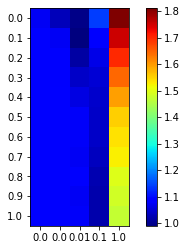

In [34]:
# Viewing hyper-parameter dict
a = ht_dict[0]
fig, ax = plt.subplots()
pos = ax.imshow(a, cmap='jet')
ax.set_yticks(np.arange(lratio_range.shape[0]))
ax.set_yticklabels(np.round(lratio_range,2))
ax.set_xticks(np.arange(c_range.shape[0]))
ax.set_xticklabels(np.round(c_range,2))
fig.colorbar(pos)

In [35]:
sample = this_best_model.coef_
sample.shape

(3, 54)

In [36]:
print(np.argwhere(sample != 0))

[[ 0  8]
 [ 0  9]
 [ 0 11]
 [ 0 27]
 [ 0 30]
 [ 1  0]
 [ 1  3]
 [ 1 15]
 [ 1 23]
 [ 1 25]
 [ 1 45]
 [ 2 11]
 [ 2 17]
 [ 2 40]
 [ 2 50]
 [ 2 52]]
